# Gesture Recognition
In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started.

In [1]:
import numpy as np
import os
#from scipy.misc import imread, imresize
from skimage.transform import resize
import datetime
import os
os.getcwd()
from matplotlib.pyplot import imread

We set the random seed so that the results don't vary drastically.

In [2]:
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
tf.random.set_seed(30)

Using TensorFlow backend.


In [22]:
#additional libraries imported for visual analysis
import matplotlib.pyplot as plt

In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [3]:
train_doc = np.random.permutation(open(os.getcwd()+"/Project_data/train.csv").readlines())
val_doc = np.random.permutation(open(os.getcwd()+"/Project_data/val.csv").readlines())
batch_size = 30

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [4]:
img_size=128
no_of_images_in_folder=15
crop_value=0
def generator(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    img_idx = list(range(0,30,2))
    while True:
        t = np.random.permutation(folder_list)
        num_batches = int(len(t)/batch_size)
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size,len(img_idx),img_size,img_size,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    #image=image[crop_value:-crop_value,crop_value:-crop_value,:]
                    image=resize(image[:,:,:],(img_size,img_size),anti_aliasing=True)
                    batch_data[folder,idx,:,:,0] = (image[:,:,0] - np.percentile(image[:,:,0],5))/(np.percentile(image[:,:,0],95) - np.percentile(image[:,:,0],5))
                    batch_data[folder,idx,:,:,1] = (image[:,:,1] - np.percentile(image[:,:,1],5))/(np.percentile(image[:,:,1],95) - np.percentile(image[:,:,1],5))
                    batch_data[folder,idx,:,:,2] = (image[:,:,2] - np.percentile(image[:,:,2],5))/(np.percentile(image[:,:,2],95) - np.percentile(image[:,:,2],5))
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

        
        # write the code for the remaining data points which are left after full batches
        rem_batch_size=len(t)-(num_batches*batch_size)
        rem_batch_data = np.zeros((rem_batch_size,len(img_idx),img_size,img_size,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
        rem_batch_labels = np.zeros((rem_batch_size,5)) # batch_labels is the one hot representation of the output
        for folder in range(rem_batch_size): # iterate over the batch_size
            imgs = os.listdir(source_path+'/'+ t[folder+(num_batches*batch_size)].split(';')[0]) # read all the images in the folder
            for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                image = imread(source_path+'/'+ t[folder+(num_batches*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                #image=image[crop_value:-crop_value,crop_value:-crop_value,:]
                image=resize(image[:,:,:],(img_size,img_size),anti_aliasing=True)
                rem_batch_data[folder,idx,:,:,0] = (image[:,:,0] - np.percentile(image[:,:,0],5))/(np.percentile(image[:,:,0],95) - np.percentile(image[:,:,0],5))
                rem_batch_data[folder,idx,:,:,1] = (image[:,:,1] - np.percentile(image[:,:,1],5))/(np.percentile(image[:,:,1],95) - np.percentile(image[:,:,1],5))
                rem_batch_data[folder,idx,:,:,2] = (image[:,:,2] - np.percentile(image[:,:,2],5))/(np.percentile(image[:,:,2],95) - np.percentile(image[:,:,2],5))
            rem_batch_labels[folder, int(t[folder+(num_batches*batch_size)].strip().split(';')[2])] = 1
        yield rem_batch_data, rem_batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [5]:
curr_dt_time = datetime.datetime.now()
train_path = os.getcwd()+"/Project_data/train"
val_path = os.getcwd()+"/Project_data/val"
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 50
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 50


## Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

In [9]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, Dropout,LSTM,GlobalAveragePooling2D
from keras.layers.convolutional import Conv3D, MaxPooling3D,Conv2D,MaxPooling2D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau,EarlyStopping
from keras import optimizers
from tensorflow.keras import regularizers

#additional imports
from keras.applications.resnet50 import ResNet50
from keras.applications import MobileNet

from keras.models import Model
import keras


#write your model here
#Importing MobileNet as we need a model with optimal number of parameters and can be used in embedded devices such as mobiles/webcam


In [10]:
restnet = MobileNet(include_top=False, weights='imagenet', input_shape=(img_size,img_size,3))
output = restnet.layers[-1].output
output= GlobalAveragePooling2D()(output)
restnet = Model(inputs=restnet.input, outputs=output)
for layer in restnet.layers:
    layer.trainable = False
restnet.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 128, 128, 3)       0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 129, 129, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 64, 64, 32)        864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 64, 64, 32)        128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 64, 64, 32)        0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 64, 64, 32)        288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 64, 64, 32)        128 

In [11]:
len(restnet.layers)

88

In [12]:
split_at = 75
for layer in restnet.layers[:split_at]: layer.trainable = False
for layer in restnet.layers[split_at:]: layer.trainable = True

In [13]:
model=Sequential()
model.add(TimeDistributed(restnet,input_shape=(no_of_images_in_folder,img_size,img_size,3)))
model.add(Dropout(0.5))
model.add(GRU(16,activation='relu',return_sequences=True))
model.add(Dropout(0.5))
model.add(GRU(16,activation='relu'))
model.add(Dropout(0.5))
# softmax layer
model.add(Dense(5, activation='softmax'))
# model summary
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_1 (TimeDist (None, 15, 1024)          3228864   
_________________________________________________________________
dropout_1 (Dropout)          (None, 15, 1024)          0         
_________________________________________________________________
gru_1 (GRU)                  (None, 15, 16)            49968     
_________________________________________________________________
dropout_2 (Dropout)          (None, 15, 16)            0         
_________________________________________________________________
gru_2 (GRU)                  (None, 16)                1584      
_________________________________________________________________
dropout_3 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 5)                

Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

In [14]:
optimiser = optimizers.adam()
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_1 (TimeDist (None, 15, 1024)          3228864   
_________________________________________________________________
dropout_1 (Dropout)          (None, 15, 1024)          0         
_________________________________________________________________
gru_1 (GRU)                  (None, 15, 16)            49968     
_________________________________________________________________
dropout_2 (Dropout)          (None, 15, 16)            0         
_________________________________________________________________
gru_2 (GRU)                  (None, 16)                1584      
_________________________________________________________________
dropout_3 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 5)                

Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

In [15]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [16]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR =  ReduceLROnPlateau(monitor='val_loss', factor=0.2,patience=5, min_lr=0.0001)
callbacks_list = [checkpoint,LR]

The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.

In [17]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [18]:
history=model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/50Source path = 
Source path =   D:\upgrad\gesturerecognition/Project_data/train ; batch size = 30D:\upgrad\gesturerecognition/Project_data/val
 ; batch size = 30
23/23 [==============================] - 242s 11s/step - loss: 1.5958 - categorical_accuracy: 0.2866 - val_loss: 1.5521 - val_categorical_accuracy: 0.3600

Epoch 00001: saving model to model_init_2020-09-1310_25_03.767652/model-00001-1.59132-0.28658-1.55210-0.36000.h5
Epoch 2/50
23/23 [==============================] - 179s 8s/step - loss: 1.4064 - categorical_accuracy: 0.3741 - val_loss: 1.6081 - val_categorical_accuracy: 0.2500

Epoch 00002: saving model to model_init_2020-09-1310_25_03.767652/model-00002-1.40399-0.37406-1.60810-0.25000.h5
Epoch 3/50
23/23 [==============================] - 178s 8s/step - loss: 1.2396 - categorical_accuracy: 0.5309 - val_loss: 1.6005 - val_categorical_accuracy: 0.5400

Epoch 00003: saving model to model_init_2020-09-1310_25_03.767652/model-00003-1.23472-0.53092-1.60046-0.54000.h5
Ep

Epoch 30/50
23/23 [==============================] - 179s 8s/step - loss: 0.4091 - categorical_accuracy: 0.9170 - val_loss: 0.9282 - val_categorical_accuracy: 0.8700

Epoch 00030: saving model to model_init_2020-09-1310_25_03.767652/model-00030-0.40753-0.91704-0.92821-0.87000.h5
Epoch 31/50
23/23 [==============================] - 178s 8s/step - loss: 0.4689 - categorical_accuracy: 0.8974 - val_loss: 0.5849 - val_categorical_accuracy: 0.8700

Epoch 00031: saving model to model_init_2020-09-1310_25_03.767652/model-00031-0.42773-0.89744-0.58491-0.87000.h5
Epoch 32/50
23/23 [==============================] - 178s 8s/step - loss: 0.5159 - categorical_accuracy: 0.8778 - val_loss: 0.2275 - val_categorical_accuracy: 0.8700

Epoch 00032: saving model to model_init_2020-09-1310_25_03.767652/model-00032-0.46137-0.87783-0.22747-0.87000.h5
Epoch 33/50
23/23 [==============================] - 178s 8s/step - loss: 0.3944 - categorical_accuracy: 0.9291 - val_loss: 0.4922 - val_categorical_accuracy: 0

# Plots for Visual Analysis

In [19]:
history_dropout=history

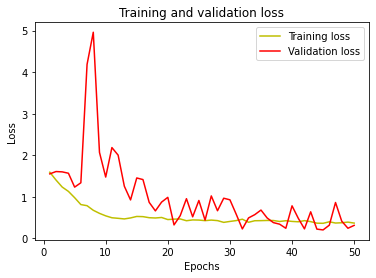

In [20]:
loss = history_dropout.history['loss']
val_loss = history_dropout.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

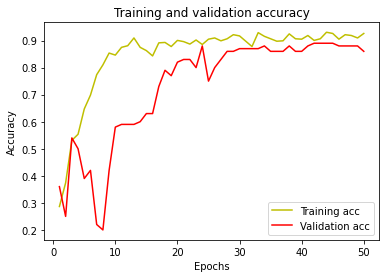

In [21]:
acc = history_dropout.history['categorical_accuracy']
val_acc = history_dropout.history['val_categorical_accuracy']
plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

<b> Training Loss and Accuracy looks to be stable and increasing over epochs<br>
    Validation Loss and Accuracy loos to waver a lot initially but gets stable after 20 epochs and gets increasing over epochs after that.<br>
    From the plot model looks to be more stable at 42 epoch where both training and validation has accuracies of 0.90 and 0.89 repectively. So model weights at this epoch is taken as best possible model from this analysis    
    